<script>
    document.querySelector('head').innerHTML += '<style>.slides { zoom: 1.0 !important; }</style>';
</script>
<!--# STAT 207: Data Science Exploration-->

## Logistic Regression

Linear regression is the first model considered when the response variable is numeric. If the response is binary or categorical, however, a different modeling approach will be more effective. The idea is to model the probability of each response category as a function of explanatory variables.


First, let's recall the properties of a simple Bernoulli random variable, which we'll denote by $Y$. Assume $Y$ is either 0 or 1, with $P(Y=1) = p$ and $P(Y=0) = 1-p$. We know that $E(Y) = p$, so we might consider allowing $p$ to follow a linear model in some explanatory variables $X_1, X_2, \ldots, X_p$. But there are two problems with this approach:

+ Ordinary least squares is no longer efficient, because the variance, $Var(Y) = p(1-p)$ is not constant, but instead depends on $p$.


+ A **linear** model for $p$ can produce estimated probabilities bigger than 1 or less than 0! 



**Logistic regression,** also known as **logit regression**, solves both of these problems:

+ It ensures the probability estimates are in the range (0,1); it produces a sigmoidal model for probability as a function of the linear regression that is bounded between 0 and 1.


+ It replaces ordinary least squares by maximum likelihood to give efficient estimates. 


Logistic regression models are built on the **log-odds (also called logit)** of the outcome of interest, and we will see that **odds-ratios** provide a useful parameter for describing relations between categorical variables and the explanatory variables.


This section is organized as follows. 

+ We first discuss the relation between probabilities and odds, and use the odds formulation to explore association between categorical variables in 2 x 2 contingency tables. These are frequency cross classification tables. 


+ We will see how the odds ratio captures dependence between the two variables in the table. We also develop confidence intervals and tests based on the logarithnic transformation of the ods ratio.


+ These ideas form the basis for building regression models for the log-odds (the logit) of the response categories. These models are analogous to linear regression models. To fit the models we use the maximum likelihood method in place of ordinary least squares.


+ Like linear regression models, logistic regression models have coefficients that we can interpret, test, and compute confidence intervals for.


+ We'll see a number of examples of logistic regression in action.



 Main Python libraries and functions:

    Pandas, NumPy, StatsModels
    pandas.DataFrame.crosstab
    statsmodels.formula.api.logit


### Probability and odds


First consider horse racing. What does it mean to say that the odds against a given horse winning are 9 to 1? Think of it as "chances" in a box of tickets. For every 1 "chance" of winning there are 9 "chances" of losing. If $p$ is the probability of winning, then we see that

$$
p = {\mbox{Number of chances of winning} \over \mbox{Total number of chances}} = {1 \over 1 + 9} = {1 \over 10}
$$

Thus 9 to 1 odds against winning the race means that the horse has a 1/10 probability of winning and 9/10 probability of losing.  We also see that

$$
\mbox{odds of winning} = 
{\mbox{Number of chances of winning} \over \mbox{Number of chances of losing}} = 
 {1 \over 9} = 1:9 = {1/10 \over 9/10} = {p \over 1-p}
$$

and

$$
\mbox{odds against winning} = 
{\mbox{Number of chances of losing} \over \mbox{Number of chances of winning}} =
{9 \over 1} = 9:1 = {1-p \over p}
$$

In general, the probability $p$ of an event is related to the odds of the event as follows:

$$
\mbox{odds} = {p \over 1-p}\quad \mbox{and} \quad p = {\mbox{odds} \over 1 + \mbox{odds}}.
$$

**Example:** If a horse is a 24 to 1 long shot to win the race, what is the probability that the horse wins the race?

In [1]:
p=1/(24+1)
p

0.04

**Example:** If there is a 40% chance of rain what are the odds that it won't rain?

In [2]:
p=0.4
odds = 6/4
p, odds

(0.4, 1.5)

**Example:** In the Pew Research Center Survey of February 2017, Question 52 asked: "All in all, would you favor or oppose building a wall along the entire border with Mexico?"

Use the data to estimate the probability and the odds that a randomly dialed survey respondent at that time would favor building the wall.

In [3]:
import numpy as np
import pandas as pd
import zipfile as zp

In [4]:
# read q52 data from zip file and get category counts
zf = zp.ZipFile('../data/Feb17-public.zip')
q52 = pd.read_csv(zf.open('Feb17public.csv'))['q52']
counts = q52.value_counts()
counts

Oppose                       947
Favor                        515
Don't know/Refused (VOL.)     41
Name: q52, dtype: int64

In [5]:
prop = counts['Favor']/sum(counts)
odds = prop / (1-prop)
print('Proportion: '+str(round(prop,4))+', Odds: '+str(round(odds,4)))

Proportion: 0.3426, Odds: 0.5213


### Odds ratio for a 2 x 2 contingency table

When studying the relation between two categorical variables, a useful techique is to **cross-classify** the data in a contingency table. Continuing the Pew example, let's cross-classify the answer to Question 52 with the gender of the respondent. For the purpose of this example, we combine the categories 'Oppose' and 'Don't know/Refused (VOL.)' into one "Not favor' category.

In [6]:
df = pd.read_csv(zf.open('Feb17public.csv'))[['q52','sex']]
# set 'Oppose' and 'Don't know/Refused (VOL.)' categories 
# to 'Not_favor'
df['q52'][df['q52']!='Favor'] = 'Not_favor'
df.head()

,q52,sex
0,Not_favor,Female
1,Not_favor,Female
2,Not_favor,Female
3,Favor,Male
4,Not_favor,Female


In [7]:
# use pandas crosstab function
# use 'margins=True' to include row and column sums in the table
tabl = pd.crosstab(index=df['q52'], columns=df['sex'], margins=True)
tabl

sex,Female,Male,All
q52,,,
Favor,207,308,515
Not_favor,520,468,988
All,727,776,1503


Now we can estimate the probability of favoring the wall broken down by gender. 

In [8]:
prop_F = tabl['Female']['Favor']/tabl['Female']['All']
prop_M = tabl['Male']['Favor']/tabl['Male']['All']
prop_F, prop_M

(0.28473177441540576, 0.39690721649484534)

The corresponding odds of favoring the wall are:

In [9]:
odds_F, odds_M = prop_F / (1 - prop_F), prop_M / (1 - prop_M)
odds_F, odds_M

(0.39807692307692305, 0.658119658119658)

Finally we compute the **odds ratio** for males versus females favoring the wall construction:

In [10]:
odds_ratio_MF = odds_M / odds_F
round(odds_ratio_MF, 4)

1.6532

The odds ratio for females versus males favoring the wall is the reciprocal of that for males versus females.

In [11]:
odds_ratio_FM = odds_F / odds_M
round(odds_ratio_FM, 4)

0.6049

The two odds ratios are equivalent. We just need to be careful to report the direction correctly.

**Conclusion:** In this survey, the odds that a male respondent would favor the wall was 1.65 times as high as the odds that a female respondent would favor the wall. Equivalently, the odds that a female respondent would favor the wall was only 60.5% of the odds that a male respondent would favor the wall.

How can we assess the uncertainty in the odds ratio? So far, we know how to do a z-test for the difference between the two proportions, so that gives us an alternative analysis. We will see that logistic regression provides a way to create confidence intervals for odds ratios. However, for this 2 x 2 setting there is a simple standard error formula for the logarithm of the odds ratio.

### Confidence interval for odds ratio in 2 x 2 table

It turns out there is a simple formula for the standard error of the **log-odds-ratio** in a 2 x 2 table. Therefore, we can compute a confidence interval for the log odds ratio, and then exponentiate the endpoints of the interval to get a confidence interval for the odds ratio itself.

Consider a generic table of the form

| row | column0 | column1 |
| --- | --- | --- |
| index0 | $n_{00}$ | $n_{01}$ |
| index1 | $n_{10}$ | $n_{11}$ |

We compute the odds ratio for column0 versus column1 and index0 versus index1 as:

$$
\hat{\theta} = \mbox{odds ratio} = {n_{00} / n_{10} \over n_{01} / n_{11}} = {n_{00} n_{11} \over n_{10} n_{01}}
$$

the value of $\hat{\theta}$ is always positive. if there is no relation between the index and column variables, then the odds ratio = 1.




Taking the natural log gives

$$
\hat{\beta} = \ln(\hat{\theta}) = \ln(n_{00}) - \ln(n_{10}) - \ln(n_{01}) + \ln(n_{11})
$$

and this statistic is approximately normal with mean equal to the population log odds ratio. if there is no relation between the index and column variables, then the log odds ratio is 0.

The large sample standard error formula for $\hat{\beta}$ is given by:

$$
se(\hat{\beta}) = \sqrt{{1 \over n_{00}} + {1 \over n_{10}} + 
{1 \over n_{01}} + {1 \over n_{11}}}.
$$

Derivation of this formula is beyond our scope here, but it is derived from the large sample distribution of the cell counts and a Taylor approximation.

Therefore, if we desire a 95% confidence interval for the **odds ratio**, we can first compute a 95% confidence inteval for the **log odds ratio**:

$$
(c_{lo}, c_{hi}) = (\hat{\beta} - 1.96*se(\hat{\beta}), \,\, \hat{\beta} + 1.96*se(\hat{\beta})).
$$

Then exponentiate to get the 95% confidence interval for the odds ratio:

$$
\mbox{odds ratio} \in (e^{c_{lo}}, \, e^{c_{hi}}).
$$


**Example:** Pew data example of support for border wall versus gender. Let's redo the table without the margin totals, since we don't need them.

In [12]:
# use pandas crosstab function
tabl2 = pd.crosstab(index=df['q52'], columns=df['sex'])
tabl2

sex,Female,Male
q52,,
Favor,207,308
Not_favor,520,468


In [13]:
# compute odds ratio Males odds/Female odds of support
# Note: '\' = python symbol for "continues on the next line"
OR = (tabl2.iloc[1,0]/tabl2.iloc[1,1]) \
     / (tabl2.iloc[0,0]/tabl2.iloc[0,1])
OR

1.6532474503488999

In [14]:
# log-odds-ratio and standard error
# Note: use '\' to indicate expression continues
#       on the next line
LGOR = np.log(OR)
LGOR_se = np.sqrt((1/tabl2.iloc[1,0])+ \
                  (1/tabl2.iloc[1,1])+ \
                  (1/tabl2.iloc[0,0])+ \
                  (1/tabl2.iloc[0,1]))
print("log_odds_ratio: "+str(LGOR)+", std_err: "+str(LGOR_se))

log_odds_ratio: 0.5027415053660318, std_err: 0.11017032350401101


In [15]:
# 95% confidence interval for log_odds_ratio and odds_ratio
from scipy.stats import norm
confidence = 0.95
zq = norm.ppf(1-(1-confidence)/2)
cut_lo, cut_hi = LGOR - zq*LGOR_se, LGOR + zq*LGOR_se
print("Log_odds_ratio CI: "+str((cut_lo, cut_hi)))
print("Odd_ratio CI: "+str((np.exp(cut_lo), np.exp(cut_hi))))

Log_odds_ratio CI: (0.2868116391330436, 0.7186713715990201)
Odd_ratio CI: (1.3321732605312708, 2.051705444827144)


We see that the odds ratio is significantly higher than 1 at level $\alpha=0.05$. 

### Log odds and logistic regression

In the Pew Survey example, we may think of favoring or not favoring the wall contruction as a binary response variable. We would like to examine how other variables "explain" or correlate with this response. A widely used approach is to develop a regression model, not for the expected response ($p$), but for the **log-odds** ($\log(p/(1-p)$), which is often called the **logit**.

Recall our notation for the variables and data in linear regression:



| $X_1$ | $X_2$ | $\cdots$ | $X_p$ | $Y$ |
| --- | --- | --- | --- | --- |
| $x_{11}$ | $x_{12}$ | $\cdots$ | $x_{1p}$ | $y_1$ |
| $x_{21}$ | $x_{22}$ | $\cdots$ | $x_{2p}$ | $y_2$ |
| $\vdots$ | $\vdots$ | $\cdots$ | $\vdots$ | $\vdots$ |
| $x_{n1}$ | $x_{n2}$ | $\cdots$ | $x_{np}$ | $y_n$ |




The only difference here is that $Y$ only takes on the values $0$ or $1$, (or two cateogrical values that we can encode as 0 and 1). We still refer to $X_1, X_2, \ldots, X_p$ as the exogenous or explanatory variables. $Y$ represents the binary response variable.

Letting $p = P(Y=1)$, the general logit or logistic regression model has the form of a linear model for the log-odds:

$$
\mbox{logit}(p) = \log\left({p \over 1-p}\right) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p.
$$

Because log-odds can take any value in $(-\infty, \infty)$, the linear model on this scale will produce valid probability estimates for the response. Using what we know about converting odds to probabilities, it can be shown that the model equivalently expresses the probability of Y=1 as

$$
p = {\exp(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p) \over
1 + \exp(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p) }.
$$

This is always between 0 and 1.

Efficient coefficient estimates are obtained for this model by the **method of maximum likelihood**. This is a generalization of least squares for linear regression, where in that setting the least squares criterion is equivalent to maximizing a Gaussian likelihood to to estimate the regression coefficients. Here we maximize a **Bernoulli likelihood** as a function of the regression coefficients.

**In Python statsmodels:** We can fit these models using the statsmodels.formula.api function 'logit', with similar function calls as 'ols'.


### Logistic regression with one binary explanatory variable

Let's continue the Pew data example, modeling the response to question 52 versus gender as a ccategorical variable. In order to fit the logit model we need to map the two response categories to numerical values. To do that we'll create a new binary variable 'y'. Then we fit a logit model of the form

$$
\mbox{logit}(p) = \beta_0 + \beta_1 X
$$

where $p = P(y=1)$ and $X$ is an indicator for gender. 

In [16]:
df['y']=df['q52'].map({'Not_favor':0,'Favor':1})
df.head()

,q52,sex,y
0,Not_favor,Female,0
1,Not_favor,Female,0
2,Not_favor,Female,0
3,Favor,Male,1
4,Not_favor,Female,0


In [17]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [18]:
mod1 = smf.logit(formula='y ~ sex', data=df).fit()
mod1.summary()

Optimization terminated successfully.
         Current function value: 0.635765
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1503
Model:                          Logit   Df Residuals:                     1501
Method:                           MLE   Df Model:                            1
Date:                Wed, 01 Apr 2020   Pseudo R-squ.:                 0.01091
Time:                        15:00:59   Log-Likelihood:                -955.55
converged:                       True   LL-Null:                       -966.09
                                        LLR p-value:                 4.412e-06
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.9211      0.082    -11.208      0.000      -1.082      -0.760
sex[T.Male]     0.5027      0.110      4.563      0.000       0.287       0.719
===============================================================================
"""

#### Fitted model

Based on these results, the fitted model has the form:

$$
\log(\mbox{odds}) = -0.9211 + 0.5027 * X
$$

where

$$
X = 
\begin{cases}
0, & \text{Female}\\
1, & \text{Male}\\
\end{cases}
$$





#### Interpretation of the regression coefficent

Notice that the log odds ratio for q52bin=1 versus 0 for males versus females is given by

$$
\begin{align}
\log\left({\mbox{odds}_M \over \mbox{odds}_F}\right) &= \, \log(\mbox{odds}_M) - \log(\mbox{odds}_F) \\
\\
&= \, (-0.9211 + 0.5027 * 1) - (-0.9211 + 0.5027 * 0) = 0.5027\\
\\
&= \, \hat{\beta}_1.\\
\end{align}
$$

Exponentiating, we obtain the estimated odds ratio of 

$${\mbox{odds}_M \over \mbox{odds}_F} =  e^{\hat{\beta}_1} =  1.65.$$ 

This is the same as we calculated for the 2 x 2 table by converting the sample proportions to an odds ratio.

Calculation details:

In [19]:
mod1.params

Intercept     -0.921110
sex[T.Male]    0.502742
dtype: float64

In [20]:
np.exp(mod1.params['sex[T.Male]'])

1.653247450348894

#### Confidence intervals and coefficient  z tests

The model summary gives us a standard error for the log-odds-ratio, $\hat{\beta}_1$, of 0.110, and a normal approximation 95% confidence interval of (0.287, 0.719). Exponentiating the endpoints of this confidence intrerval gives us a 95% confidence interval for the M versus F odds ratio:

In [21]:
(round(np.exp(0.287), 4), round(np.exp(0.719), 4))

(1.3324, 2.0524)

**Null hypothesis of no gender effect.** If there were no gender difference in support from the wall, the log-odds-ratio for male versus female would be zero, which corresponds to an odds ratio of 1. In terms of the model parameters we write, using the log-odds-ratio

$$H_0: \beta_1=0$$ 

or using the odds ratio

$$H_0: e^{\beta_1} = 1$$

Since the 95% confidence interval for the odds ratio excludes 1, the odds ratio is statistically significantly differen from 1, at the level 0.05.

Alternatively, we note that $z = \hat{\beta}_1 / se(\hat{\beta}_1)$ has a p-value  < 0.0005, so the test would reject at level 0.05 (and level 0.01 for that matter).

### Logistic regression with one numerical explanatory variable


Let's consider some simulated data where we know the correct model. This will allow us to understand the workings of the model better.

#### Example: Simulated data from the logit model

In [22]:
from scipy.stats import norm, bernoulli

In [23]:
# set the coefficient values
b0, b1 = -0.7, 2.1  
#
# generate exogenous variable:
x = norm.rvs(size=100, random_state=12347) 
#
# create the odds vector that depends on x
odds = np.exp(b0 + b1*x)
#
# convert odds to probabilities and generate response y
y = bernoulli.rvs(p=odds/(1+odds), size=100, random_state=1)
dat = pd.DataFrame({'x':x, 'y':y})
dat.head(10)

,x,y
0,0.343687,1
1,1.848400,1
2,0.224359,0
3,-1.633660,0
4,1.245538,1
5,1.712812,1
6,-0.687918,0
7,-1.186239,0
8,-0.400249,0
9,-0.303626,0


In [24]:
sum(dat.y)

46

Let's make a scatter plot with the true probability curve included.

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

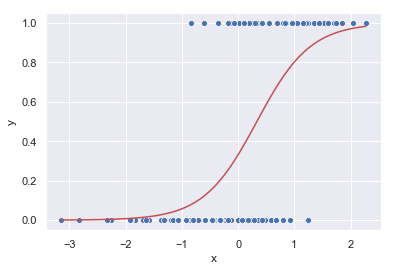

In [26]:
# plot raw data
sns.scatterplot(x='x', y='y', data=dat) 
#
# make a grid of x values for plotting the curve
xgrid = np.linspace(dat['x'].min(), dat['x'].max(), 100)
#
# compute odds over the grid
ogrid = np.exp(b0 + b1*xgrid)
#
# graph the probability curve
plt.plot(xgrid, ogrid/(1+ogrid), color='r')  
plt.show()

**Probability curve:** In the graph above the probability curve has the sigmoidal form,

$$
P(Y=1) = { \exp(\beta_0 + \beta_1 X) \over  1 + \exp( \beta_0 + \beta_1 X)}
$$

where in the simulation model we set $\beta_0 = -0.7$ and $\beta_1 = 2.1$. On the odds scale, this is the same as

$$
\mbox{odds}(Y=1) = {P(Y=1) \over P(Y=0) } = \exp(\beta_0 + \beta_1 X) = e^{\beta_0} (e^{\beta_1})^X
$$

Therefore, $e^{\beta_1}$ is the odds multiplier associated with $X$. Increasing or decreasing $X$ by 1 unit multiplies or divides the odds by the factor $e^{\beta_1}$.

In the example the odds multiplier is $e^{2.1} = 8.17$.

In [27]:
np.exp(2.1)

8.166169912567652

We see how the probability varies over the range of $x$. This leads to varying densities of $y=0$ and $y=1$ as a function of $x$.

We can also roughly visualize the density shift using a horizontal box plot of x versus y. 

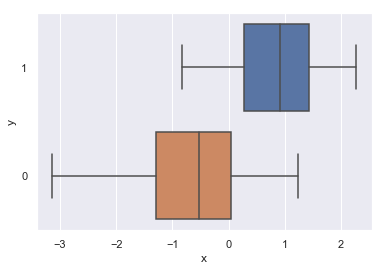

In [28]:
sns.boxplot(x='x', y='y', data=dat, orient='h', order=[1,0])
plt.show()

#### Fitted logistic regression model

Let's fit a logit model to the simulated data and examine the model summary.

In [29]:
simmod = smf.logit('y ~ x', data=dat).fit()
simmod.summary()

Optimization terminated successfully.
         Current function value: 0.403715
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Wed, 01 Apr 2020   Pseudo R-squ.:                  0.4149
Time:                        15:01:00   Log-Likelihood:                -40.371
converged:                       True   LL-Null:                       -68.994
                                        LLR p-value:                 3.846e-14
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4938      0.291     -1.697      0.090      -1.064       0.076
x              2.2133      0.440      5.028      0.000       1.350       3.076
==============================================================================
"""

In [30]:
np.exp(-0.4938), np.exp(2.2133)

(0.6103028314517273, 9.145847946856755)

Here the fitted model has the form:

$$
\log\left({p(X) \over 1 - p(X)}\right) = -0.4938 + 2.2133 * X
$$

where the dependence of $p(X)$ on $X$ is added for emphasis. 

What is the meaning of the regression coefficient of $X$? We can interpret it as the log-odds-ratio associated with a 1 unit change in X:

$$
\mbox{odds}(X) = {p(X) \over 1 - p(X)} = e^{-0.4938} * (e^{2.2133})^X
$$


+ **Baseline odds:** $e^{-0.4938}=0.61$ equals the estimate odds of $Y=1$ if $X=0$;


+ **Odds multiplier:** $e^{2.2133}=9.15$ is the estimated odds multiplier associated with each one unit increase in $X$. 




In publications, the logistic regression coefficents are often expressed in exponentiated form as odds ratios, along with confidence intervals for the odds ratios. The scale of an odds ratio is easier to interpret than the scale of a log odds ratio.

For the present model we have:

In [31]:
pd.DataFrame({'x coef': [2.2133, np.exp(2.2133)],
              '[0.025': [1.350, np.exp(1.350)],
              '0.975]': [3.076, np.exp(3.076)]}, 
             index=['log-odds-ratio', 'odds-ratio'])

,x coef,[0.025,0.975]
log-odds-ratio,2.213300,1.350000,3.076000
odds-ratio,9.145848,3.857426,21.671543


#### Coefficient z test

Under general conditions the logistic regression coeficients are approximately normally distributed. The assumptions include that all the data are independent, and assuming the logit model is correctly specified. The logistic regression coeffiicent estimates $\hat{\beta_0}$, $\hat{\beta_1}$ etc. are approximately normally distributed with means equal to the population coeffiicents $\beta_0$, $\beta_1$ etc. Furthermore, consistent **standard errors** can be computed from the observed information matrix, which is discussed in more advanced courses. 

For our purposes, we note that the standard errors are routinely provided in statistical modeling software such as the statmodels.formula.api logit function. 




Therefore, if we wish to test a coefficient null hypothesis such as

$$
H_{0}: \beta_1 = 0\quad \mbox{against} \quad H_{A}: \beta_1 \ne 0,
$$

we can use the corresponding z statistic reported in the model summary:

$$
z = {\hat{\beta}_1 \over se(\hat{\beta}_1)}
$$

and compute a large sample p-value as

$$
\mbox{p_value} = 2 * P(Z < -\vert z \vert)
$$

where $Z$ represents a standard normal random variable. We can compute this using the scipy.stats 'norm.cdf' function.


In our example, however, the model summary already provides these values. From the summary:

$$
𝑧=5.028 \quad \mbox{and} \quad \mbox{p_value}\approx 0.000
$$
 
Therefore we would reject the null hypothesis, even for $\alpha=0.001$.

Because these are simulated data, we know that this decision is correct; the population value for $\beta_1$  is 2.1.

### Logistic regression with multiple explanatory variables.

#### Example: using 'age' and 'sex' to predict response 'q52' in the Pew survey

It turns out there were nonstandard missing values in the 'age' column. As noted in Chapter 2, these will cause pandas to read the age column as categories unless we flag the nonstandard missing values. So we will do that here. Notice that we need double brackets [['age', 'sex', 'q52']] to subset multiple columns of the data frame because the inner brackets enclose the list.

In [32]:
missing_values = ["NaN", "nan", "Don't know/Refused (VOL.)"]
df = pd.read_csv(zf.open('Feb17public.csv'), 
                 na_values=missing_values)[['age', 'sex', 'q52']]

In [33]:
# reduce q52 responses to two categories and 
# create binary reponse variable
df['q52'][df['q52']!='Favor'] = 'Not_favor'
df['y'] = df['q52'].map({'Not_favor':0,'Favor':1})
df.head(10)

,age,sex,q52,y
0,80.0,Female,Not_favor,0
1,70.0,Female,Not_favor,0
2,69.0,Female,Not_favor,0
3,50.0,Male,Favor,1
4,70.0,Female,Not_favor,0
5,78.0,Male,Not_favor,0
6,89.0,Female,Not_favor,0
7,92.0,Female,Not_favor,0
8,54.0,Female,Favor,1
9,58.0,Female,Not_favor,0


In [34]:
mod2 = smf.logit('y ~ age + sex', data=df).fit()
mod2.summary()

Optimization terminated successfully.
         Current function value: 0.617205
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1489
Model:                          Logit   Df Residuals:                     1486
Method:                           MLE   Df Model:                            2
Date:                Wed, 01 Apr 2020   Pseudo R-squ.:                 0.03700
Time:                        15:01:01   Log-Likelihood:                -919.02
converged:                       True   LL-Null:                       -954.33
                                        LLR p-value:                 4.623e-16
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.1237      0.195    -10.882      0.000      -2.506      -1.741
sex[T.Male]     0.5496      0.113      4.849      0.000       0.327       0.772
age             0.0226      0.003      6.993      0.000       0.016       0.029
===============================================================================
"""

#### Interpretation of results

The estimated model for predicting the odds of favoring the wall has the form:

$$
\log\left({p\over 1-p}\right) = -2.1237 + 0.5496 * \mbox{sex[T.Male]} + 0.0226 * age
$$

where $\mbox{sex[T.Male]}$ = 0 for female respondents and 1 for male respondents, so females are the reference category.

The z tests of both the age and sex coefficients are highly statistically signficant (p < 0.001).


On the odds scale, the fitted model becomes
$$
\mbox{odds} = {p \over 1 - p} = e^{-2.1237} * (e^{0.5496})^\mbox{sex[T.Male]} * (e^{0.0226})^{age}
$$


Therefore, incremental odds multiplier for males versus females is

$$
e^{0.5496} = 1.73
$$

and the incremental odds multiplier for each 1 year increase in age is

$$
e^{0.0226} = 1.023.
$$

While the age mulitplier appears close to 1, this is due to scaling. Note that the multiplier for a 20 year increase in age is

$$
e^{20*0.0226} = 1.57
$$

In [35]:
np.exp(0.5496), np.exp(0.0226), np.exp(20*0.0226)

(1.7325598553020034, 1.022857314781808, 1.571451948577649)

We can compute 95% confidence intervals for odds multipliers by exponentiating the confidence intervals for the coefficents in the log-odds model:

In [36]:
print("Male v. Female odds ratio CI: " \
      +str((np.exp(0.327), np.exp(0.772))))
print("Age 1 yr odds ratio CI: " \
      +str((np.exp(0.016), np.exp(0.029))))

Male v. Female odds ratio CI: (1.3868014771803021, 2.1640901087061213)
Age 1 yr odds ratio CI: (1.016128685406095, 1.0294245944751308)


If we wish to compute the 20-year odds ratio for age instead of 1-year we can transform accordingly and still have a valid confidence interval:

In [37]:
print("Age 20 yr odds ratio CI: " \
      +str((np.exp(20*0.016), np.exp(20*0.029))))

Age 20 yr odds ratio CI: (1.3771277643359572, 1.7860384307500734)


**What if we wanted to check for possible interaction between age and gender? How should we change the model to do that?**

In [38]:
mod3 = smf.logit('y ~ age + sex + age:sex', data=df).fit()
mod3.summary()

Optimization terminated successfully.
         Current function value: 0.616819
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1489
Model:                          Logit   Df Residuals:                     1485
Method:                           MLE   Df Model:                            3
Date:                Wed, 01 Apr 2020   Pseudo R-squ.:                 0.03760
Time:                        15:01:01   Log-Likelihood:                -918.44
converged:                       True   LL-Null:                       -954.33
                                        LLR p-value:                 1.781e-15
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.3395      0.284     -8.233      0.000      -2.896      -1.783
sex[T.Male]         0.9213      0.366      2.518      0.012       0.204       1.638
age                 0.0265      0.005      5.380      0.000       0.017       0.036
age:sex[T.Male]    -0.0070      0.007     -1.071      0.284      -0.020       0.006
===================================================================================
"""

The interaction term reflects any difference in the age effect between genders. The z-test for the interaction is not signficant (p > 0.25), so there is no indication that this term is needed in the model.

---
STAT 207, Douglas Simpson, University of Illinois at Urbana-Champaign